# Analysis - Stack Overflow Surveys 2011 - 2020

This scripts takes the results from 2011-2020, which were combined into a single dataframe in the condition.ipynb notebook.

Made up of the following columns

- target_cols : 'salary'
- numerical_cols : 'age', 'years_coding', 'org_size'
- categorical_cols : 'os', 'satisfaction', 'job_seek', 'remote', 'gender', 'industry', 'employment',
- dummy_cols = 'occupation', 'education'
- other = 'survey_year', 'countries'

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from routines import xzload, mpl_defs, stackplot

colours = mpl_defs()

First load the dataset and have a look

,count,mean,std,min,25%,50%,75%,max
age,295531.0,30.248505,9.062109,1.0,23.0,29.0,34.0,279.0
education_associate_degree,252199.0,0.030734,0.172596,0.0,0.0,0.0,0.0,1.0
education_bachelors,385707.0,0.408953,0.491641,0.0,0.0,0.0,1.0,1.0
education_bootcamp,321246.0,0.081579,0.273723,0.0,0.0,0.0,0.0,1.0
education_college,385707.0,0.130965,0.337362,0.0,0.0,0.0,0.0,1.0
education_competition,239130.0,0.186911,0.389841,0.0,0.0,0.0,0.0,1.0
education_doctoral,385707.0,0.023391,0.151141,0.0,0.0,0.0,0.0,1.0
education_elementary,303591.0,0.016687,0.128096,0.0,0.0,0.0,0.0,1.0
education_hackathon,239130.0,0.196366,0.397249,0.0,0.0,0.0,0.0,1.0
education_industry_cert,321246.0,0.095818,0.294341,0.0,0.0,0.0,0.0,1.0


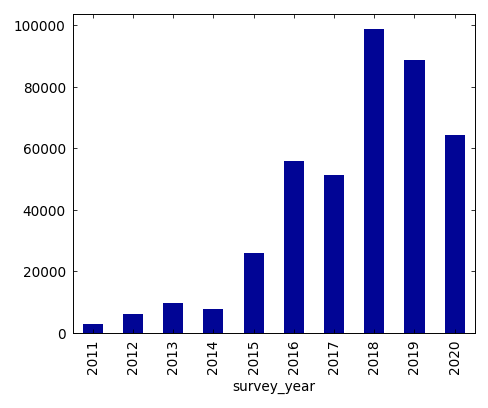

In [2]:

df = xzload("surveys.pz")
fig, ax = plt.subplots()
df.value_counts(subset='survey_year').sort_index().plot(kind="bar",ax=ax)
#ax.set_xticks(range(2011,2021))
df.describe().T

The variability in counts between columns partly comes from changes to the questions asked in each year. The reach of the survey increases dramatically from 2015, with almost 100000 in 2019.

## Participant Age

First up, participant age. Note that the question wasn't asked in 2017

,mean,std
survey_year,,
2011,30.370465,7.898700
2012,28.981556,7.897231
2013,30.083634,8.880713
2014,29.171250,8.736102
2015,28.911384,8.461626
2016,29.822719,9.022794
2017,NaN,NaN
2018,30.879410,8.912042
2019,30.336699,9.178390


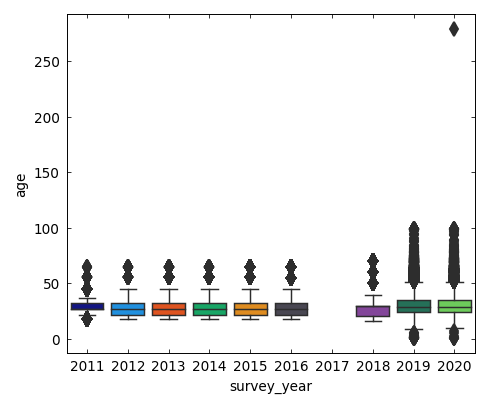

In [3]:
age = df.groupby("survey_year")["age"].agg(["mean", "std"])
sns.boxplot(data=df, x="survey_year", y="age")
age

Perhaps a slight upturn in later years, but that seems artificial due to a change in the way the question was asked. Before 2019, the response was provided as categorical ranges (the median value of the groups was selected). In 2019 to 2020 this question became numerical, but but unless there really is a 275 year old coder out there, we can assume some respondents did not answer seriously.

Let's remove these outliers from the dataframe by slightly cutting the outer quantile and look at the data again. This assumes that someone who answered this question incorrectly was not serious about filling out the survey.

,mean,std
survey_year,,
2011,30.370465,7.898700
2012,28.981556,7.897231
2013,30.083634,8.880713
2014,29.171250,8.736102
2015,28.911384,8.461626
2016,29.822719,9.022794
2018,30.770665,8.682122
2019,30.282434,8.828112
2020,30.743879,9.155968


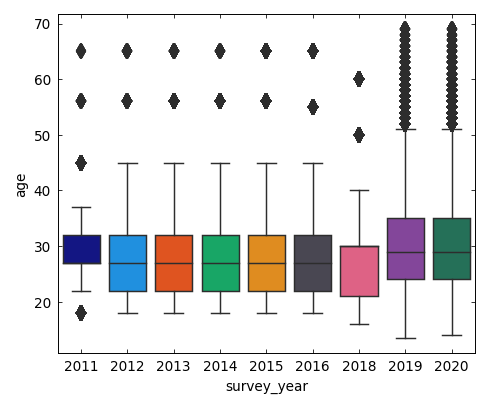

In [3]:
Q = (0.001, 0.999)
df = df[(df["age"] < df["age"].quantile(Q[1])) & (df["age"] > df["age"].quantile(Q[0]))]
sns.boxplot(data=df, x="survey_year", y="age")
df.groupby("survey_year")["age"].agg(["mean", "std"])


That's better. Interestingly despite the change in style of question, the mean age remains around 30 years old, although there does seem to be some sort of trend towards a broader distribution. The dramatic increase in partipants also doesn't seem to have any impact upon average age.

## Years Coding

Let's see how the years coding also changes over time

,mean,std,pc50
survey_year,,,
2011,7.459509,3.513577,8.0
2012,6.405600,3.713988,8.0
2013,6.701293,3.745201,8.0
2014,6.157773,3.813739,8.0
2015,6.723255,5.230673,3.0
2016,7.033112,5.308980,3.0
2018,10.526351,7.840898,7.0
2019,11.508761,8.717525,9.0
2020,12.689641,9.276794,10.0


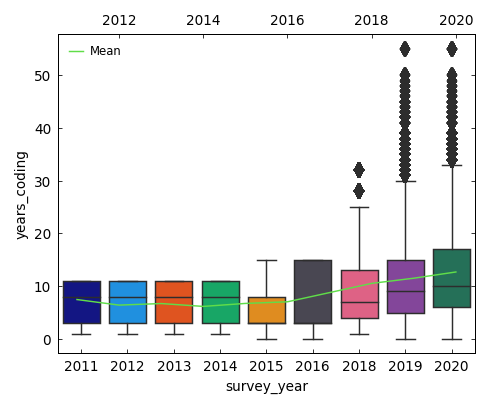

In [13]:
def pc50(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 50)

fig, ax = plt.subplots()
g = sns.boxplot(data=df, x="survey_year", y="years_coding", ax=ax)

yc = df.groupby("survey_year")["years_coding"].agg(["mean", "std", pc50])
axt = ax.twiny()
axt.plot(yc["mean"], label="Mean", color=colours[-2])
axt.legend(loc=2)

yc

The years coding does seem to increase over time when looking at both the mean and 50th percentile. At the same time, the average age remained mostly constant. This is likely due to the change in question format, or perhaps participants in later years starting picking up coding at an earlier age. Finally, we can compare age and years coding for the 2015 and 2020. Which really shows the strong correlation between the distributions, at least in the 2020 set.

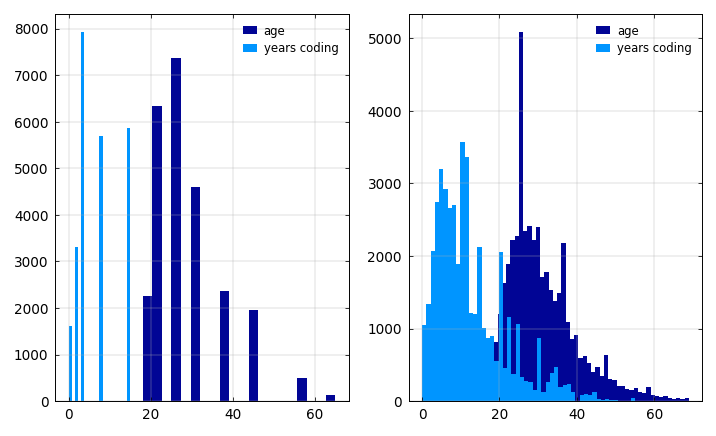

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
for ax, bins, year in zip(axes, [20, 50], [2015, 2020]):
    df[df.survey_year == year]["age"].hist(bins=bins, ax=ax, label='age')
    df[df.survey_year == year]["years_coding"].hist(bins=bins, ax=ax, label='years coding')
    ax.legend()


## Organisation Size

Organisation size is a difficult one, since the spread is decididly non-linear, ranging from self-employed to corporations 10000+. We can see how changes in the bucketing of the question changes over time.

,mean,std
survey_year,,
2011,2336.262382,4101.543154
2012,2046.289373,3887.666217
2013,1729.049166,3543.752933
2016,1832.292236,3354.871002
2018,2110.369735,3538.574640
2019,2059.081694,3524.448749
2020,2046.651827,3492.239854


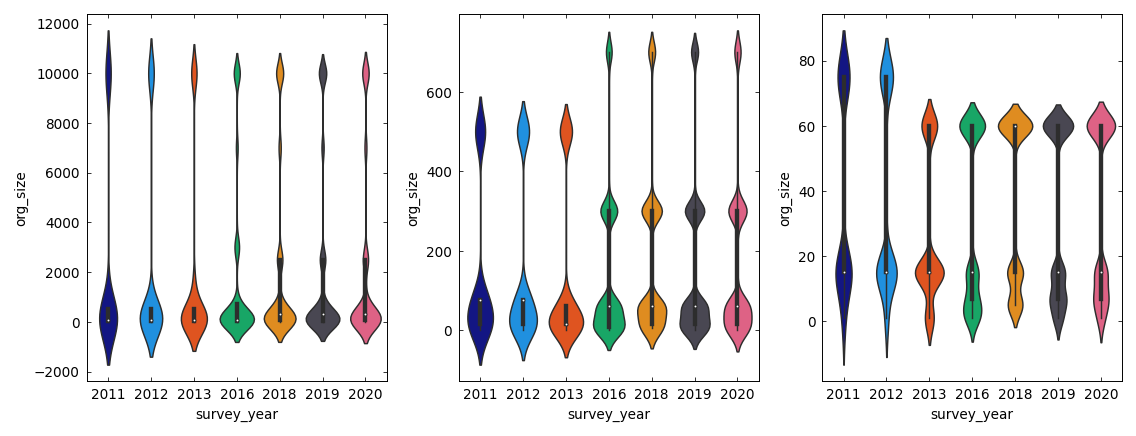

In [21]:
years = [2011, 2012, 2013, 2016, 2017, 2018, 2019, 2020]
org = df.loc[df.survey_year.isin(years)]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))
sns.violinplot(data=org, x="survey_year", y="org_size", ax=ax[0])
sns.violinplot(data=org[org.org_size < 1000], x="survey_year", y="org_size", ax=ax[1])
sns.violinplot(data=org[org.org_size < 200], x="survey_year", y="org_size", ax=ax[2])


Instead, we can try splitting up the dataets into small, medium and large

In [ ]:
sns.violinplot(data=org[org.org_size < 1000], x="survey_year", y="org_size", ax=ax[1])
sns.violinplot(data=org[org.org_size < 200], x="survey_year", y="org_size", ax=ax[2],,asfasdsafasd

In [ ]:
fig, ax = plt.subplots()
os = df.groupby('survey_year')['os'].value_counts(normalize=True).sort_index().unstack()
os.columns = ["MacOS", "Linux/BSD", "Windows"]
os.plot(ax=ax)
ax.set_title('Most used Operating System')
ax.set_xticks(range(2011,2021))
ax.margins(0,0)

In [ ]:
# %% satisfaction

sat = df.groupby("survey_year")["satisfaction"].value_counts(normalize=True).sort_index().unstack()
sat.columns = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
ax = stackplot(sat.drop([2017, 2018]), "Satisfaction")


In [ ]:

fig, ax = plt.subplots()
js = df.groupby("survey_year")["job_seek"].value_counts(normalize=True).sort_index().unstack()
js.columns = ["Actively looking", "Not looking", "Open to new opportunities"]
js.drop(2014).plot(ax=ax)
ax.set_title('Looking for a new job?')
ax.set_xticks(range(2011,2021))
ax.margins(0, 0.05)

In [ ]:
emp = df.groupby("survey_year")["employment"].value_counts(normalize=True).sort_index().unstack()
emp = emp[["not-employed", "independent", "part-time", "full-time"]]
emp.columns = [
    "Not employed (student/retired/unemployed)",
    "Independent (contractor/self-employed)",
    "Part time position",
    "Full time position"
]
ax = stackplot(emp, "Employment Status")

In [ ]:
rem = df.groupby("survey_year")["remote"].value_counts(normalize=True).sort_index().unstack()
rem = rem[["never",  "occasional", "part_time", "full_time"]]
rem.columns = ["Never", "Occasionaly", "Part time", "All the time"]
ax = stackplot(rem, 'Remote Working')
ax.legend(loc=4, frameon=True)

In [ ]:
gen = df.groupby("survey_year")["gender"].value_counts().sort_index().unstack()
gen.columns = ["Female", "Male", "Other\nNon-binary\nTransgender\nGenderqueer\nGender non-conforming"]
ax = stackplot(gen, "Gender")
ax.legend(loc=2)
ax.set_ylabel('Participants')

gen = df.groupby("survey_year")["gender"].value_counts(normalize=True).sort_index().unstack()
np.round(gen.T*100, 1)

In [ ]:
ind = df.groupby("survey_year")["industry"].value_counts(normalize=True).sort_index().unstack()

ind = ind[[
    "consulting",
    "education",
    "finance",
    "gaming",
    "healthcare",
    "manufacturing",
    "non-profit",
    "retail",
    "software",
    "web"
]].drop(2017)

ax = stackplot(ind, "Select Industries", cmap="icefire_r")
ax.legend(loc=2, fontsize='small', ncol=4)

np.round(ind.T*100, 1)
ind.T.plot(kind="bar", cmap="icefire_r")

np.round(ind.T*100, 1)

In [ ]:
occ_cols = [c for c in df.columns if c.startswith("occupation")]

occ = df[["survey_year"]+occ_cols].groupby("survey_year").sum()
occ.columns = [c.split("_", 1)[-1] for c in occ_cols]

occ_interest = [
    # 'student',  # ignore students
    'other',
    'non-tech',
    'academic',
    'data_engineer',
    'data_scientist',
    'analyst',
    'database',
    'DevOps',
    'executive',
    'manager',
    'admin',
    'QA',
    # 'sales',  very small contribution
    'designer',
    'dev_desktop',
    'dev_embed',
    'dev_enterprise',
    'dev_graphics',
    # 'dev_kernel',  # only included in early surveys
    'dev_mobile',
    'dev_server',
    'dev_stats',
    'dev_web-back',
    'dev_web-front',
    'dev_web-full',
    'dev_web',
]

occ = occ[occ_interest]

fig, ax = plt.subplots(figsize=(5,3))
ax = stackplot(occ, "occupations", cmap="Spectral", ax=ax)
ax.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=2)

occ = occ.divide(occ.sum(axis=1).values, axis=0)
occ.columns = [c.split("_", 1)[-1] for c in occ_interest]

fig, ax = plt.subplots(figsize=(5,3))
ax = stackplot(occ.drop([2015,2017]), "occupations", cmap="tab20c", ax=ax)
ax.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=2)

In [ ]:
occ_cols = [c for c in df.columns if c.startswith("occupation")]
occ = df[["survey_year"]+occ_cols].replace(np.nan, 0).groupby("survey_year").mean()

occ.columns = [c.split("_", 1)[-1] for c in occ_cols]
occ = occ[[
    'data_engineer',
    'data_scientist',
    'academic',
    'database',
    'analyst',
    'other',
]]

ax = stackplot(occ, "occupations")
ax.legend(loc=2, ncol=2)

fig, ax = plt.subplots()
for o in occ:
    l, = ax.plot(occ.index, occ[o], lw=1, label=o)
    if o == 'other':
        l.set_dashes((2, 2))
ax.legend(loc=2)
ax.margins(0,0.05)

np.round(occ*100, 2)

In [ ]:
occ_cols = [c for c in df.columns if c.startswith("occupation")]
occ = df[["survey_year"]+occ_cols].loc[df.occupation_data_scientist == 1]
occ = occ.groupby("survey_year").mean()

occ.columns = [c.split("_", 1)[-1] for c in occ_cols]
occ = occ.dropna(axis=1, how='all').sort_values(by=2020, axis=1, ascending=False)
np.round(occ.drop([2015,2016]).T, 3) * 100

In [ ]:
edu_cols = [c for c in df.columns if c.startswith("education")]
edu = df[["survey_year"]+edu_cols].groupby("survey_year").sum()
edu.columns = [c.split("_", 1)[-1] for c in edu_cols]

edu_formal = [
    'elementary',
    'secondary',
    'college',
    'bachelors',
    'masters',
    'doctoral',
    'associate_degree',
    'professional_degree',
]


eduf = edu[edu_formal]
dropcols = [2011, 2012, 2013, 2014]
eduf = eduf.divide(eduf.sum(axis=1).values, axis=0)
eduf = eduf.drop(dropcols).sort_values(by=2019,axis=1, ascending=False)
ax = stackplot(eduf, "formal education", cmap="vlag")
ax.legend(loc=3, ncol=2)

edu_informal = [
    'bootcamp',
    'competition',
    'hackathon',
    'mentor',
    'industry_cert',
    'night_school',
    'no_formal',
    'on_the_job',
    'online',
    'open_source',
    'self_taught'
]

edui = edu[edu_informal]
dropcols = [2011, 2012, 2013, 2014, 2020]
edui = edui.divide(edui.sum(axis=1).values, axis=0)
edui = edui.drop(dropcols).sort_values(by=2019,axis=1, ascending=False)
ax = stackplot(edui, "informal education", cmap="vlag")
ax.legend(loc=4, ncol=3)


In [ ]:
edu_interest_1 = [
    'bachelors',
    'masters',
    'doctoral',
]

edu_interest_2 = [
    'bootcamp',
    'online',
    'open_source',
    'on_the_job',
    'competition',
    'night_school'
]

edu_cols = [c for c in df.columns if c.startswith("education")]
edu = df[["survey_year"]+edu_cols].replace(np.nan, 0).groupby("survey_year").mean()
edu.columns = [c.split("_", 1)[-1] for c in edu_cols]

fig, ax = plt.subplots(1, 2, figsize=(5, 3))
edu[edu_interest_1].drop([2011, 2012, 2013, 2014]).plot(ax=ax[0])
edu[edu_interest_2].drop([2011, 2012, 2013, 2014, 2020]).plot(ax=ax[1])

for axi in ax:
    axi.margins(0, 0.05)

edu = edu[edu_interest_1+edu_interest_2].drop([2011, 2012, 2013, 2014])
np.round(edu * 100, 2).T

In [ ]:
df.groupby('country').agg({'salary':'count'}).sort_values(by='salary', ascending=False).iloc[:10]

countries = [
    'United States',
    'United Kingdom',
    'India',
    'Germany',
    'Canada',
    'France',
    'Australia',
    'Russia',
    # 'Poland',
    # 'Brazil',
]

pd.pivot_table(
    df[df.country.isin(countries)],
    values='salary',
    columns=['survey_year'],
    index='country'
)

sns.violinplot(x='survey_year',y='salary',data=df.loc[df.country == "United States"])


In [ ]:
Q = 0.95
ct = df.loc[df.country == "United States"].copy()
ct = ct[ct["salary"] < ct["salary"].quantile(Q)]

sns.violinplot(x='survey_year',y='salary',data=ct)

In [ ]:
dfc = df[df.country.isin(countries)].copy()
dfc = dfc[dfc["salary"] < dfc["salary"].quantile(Q)]

pd.pivot_table(dfc, values='salary', columns=['survey_year'], index='country')

g = sns.catplot(
    x="country",
    y="salary",
    hue="survey_year",
    data=dfc,
    kind="bar",
    estimator=np.mean
)


In [ ]:
dropcols = [
    'occupation_dev_server',
    'occupation_dev_kernel',
    'occupation_non-tech'
]

Q = 0.95
ct = df.loc[df.survey_year == year]
ct = ct.loc[ct.country == "United States"].drop(dropcols, axis=1).copy()
ct = ct[ct["salary"] < ct["salary"].quantile(Q)]

covlist = ct.corr().unstack().drop_duplicates().sort_values()
covlist = covlist[covlist < 1]  # remove self correlation

covsort = []
for (f1, f2), c in covlist.iteritems():
    if f1 == 'salary':
        covsort.append(f2)
    elif f2 == 'salary':
        covsort.append(f1)

covmat = ct[['salary']+covsort[::-1]].corr()

mask = np.triu(np.ones_like(covmat, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(covmat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

covmat["salary"]

In [ ]:

def clean_data(df):

    df = df.copy()
    df.dropna(subset=['salary'], inplace=True)
    df.dropna(how='all', axis=1, inplace=True)

    y = df['salary']
    df.drop('salary', axis=1, inplace=True)

    # separate numerical from categorical
    df_num = df.select_dtypes(include=np.number)
    df_cat = df.select_dtypes(include='object')

    # join numerical with nan filled with mean and one hot encoding for categorical
    X = pd.concat([
        df_num.apply(lambda col: col.fillna(col.mean())),
        pd.get_dummies(df_cat, dummy_na=False, drop_first=True)
    ], axis=1)

    return X, y


def run_regression(X, y, cutoff=0, alpha=0, test_size=.3, random_state=19):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoff - int, cutoff for number of non-zero values in dummy categorical vars
    alpha - float, L1-regularizer
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 19, controls random state for train_test_split

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    reduce_X = X.iloc[:, (X.sum() > cutoff).values]

    X_train, X_test, y_train, y_test = train_test_split(
            reduce_X,
            y,
            test_size=test_size,
            random_state=random_state,
        )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    if alpha == 0:
        lm_model = LinearRegression()
    else:
        lm_model = Ridge(alpha=alpha)

    lm_model.fit(X_train, y_train)

    # Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    # Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    print(reduce_X.shape)
    print(train_score, test_score)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

df2 = df.copy()

for col in df.columns:
    if col.startswith("occupation_") or col.startswith("education_"):
        df2[col].isna() == 0
        # df[col] = df[col].astype('category')

Q = 0.95
df2 = df2[df2["salary"] < df2["salary"].quantile(Q)]
# df2 = df2.loc[df.country == "United States"].drop("country", axis=1)

X, y = clean_data(df2)
result = run_regression(X, y, alpha=0.01, cutoff=0)